In [307]:
%load_ext autoreload
%autoreload 2
from dataclasses import asdict
import oogeso
from oogeso.plotting_utils import plots
#import oogeso.io
import oogeso.io.file_io
from oogeso.dto.oogeso_input_data_objects import serialize_oogeso_data
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import pandas as pd
import logging
import pprint
import ipywidgets
import cloudpickle
import plotly.express as px
import pyomo.environ as pyo
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read input data and create optimisation problem

In [308]:
#timerange=[0,400] # testing
time_range = [0,6]
outpath = "results/"

data = oogeso.io.file_io.read_data_from_yaml('skjold.yaml')
with open("skjold.json","w") as f:
    f.write(serialize_oogeso_data(data))

In [309]:
#data.devices[4].start_stop
data.devices[4].penalty_function[1][0]

75000.0

In [310]:
@ipywidgets.interact(datagroup=['','devices','nodes','edges','carriers','parameters','profiles'])
def showdata(datagroup):
    pprint.pprint(asdict(data)[datagroup],indent=1) if datagroup!='' else print('')

interactive(children=(Dropdown(description='datagroup', options=('', 'devices', 'nodes', 'edges', 'carriers', …

In [311]:
# Creating simulation/optimisation object:
#data.parameters.piecewise_repn="SOS2"
sim = oogeso.Simulator(data)

INFO:root:profiles in use: ['powerdemand_skjold_C', 'powerdemand_skjold_A', 'powerdemand_skjold_B']
INFO:root:Using objective function  penalty
INFO:root:No emission_rate_max limit specified
INFO:root:No emission_intensity_max limit specified
INFO:root:No el_backup_margin limit specified


In [312]:
yy=['']+list(sim.optimiser.pyomo_instance.component_objects(oogeso.optimiser.pyo.Constraint, active=True))
@ipywidgets.interact(constraint=yy)
def showdata(constraint):
    pprint.pprint(constraint.pprint(),width=1) if constraint!='' else print('')

interactive(children=(Dropdown(description='constraint', options=('', <pyomo.core.base.constraint.IndexedConst…

In [313]:
#sim.optimiser.pyomo_instance.constrE_e1_loss[0,:].pprint()

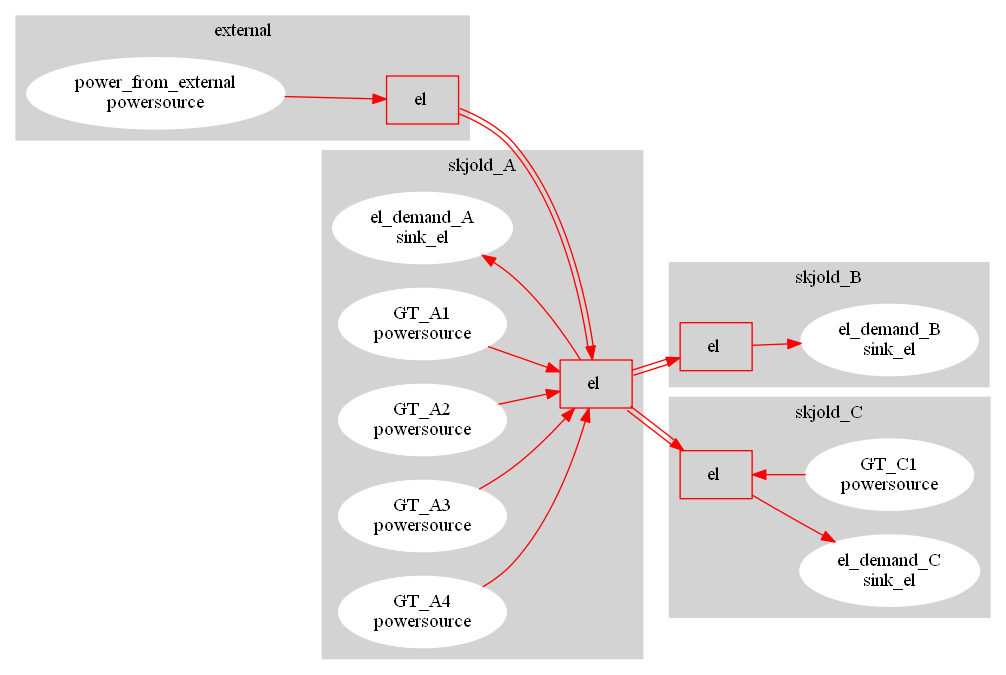

In [314]:
dotG=plots.plotNetwork(sim,timestep=None,filename=None,rankdir='LR')
IPython.display.Image(dotG.create_png())

In [315]:
#sim._df_profiles_forecast
#plots.plotProfiles({"actual":sim._df_profiles_actual,"forecast":sim._df_profiles_forecast})

## Solve

In [316]:
#print(sim._df_profiles_forecast)
#sim.optimiser.write("skjold.lp")
#sim.optimiser.pyomo_instance.objObjective.pprint()
sim.optimiser.optimisation_parameters.piecewise_repn

'CC'

In [317]:
status = sim.runSimulation(solver="gurobi",timerange=time_range,write_yaml=False,timelimit=20)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


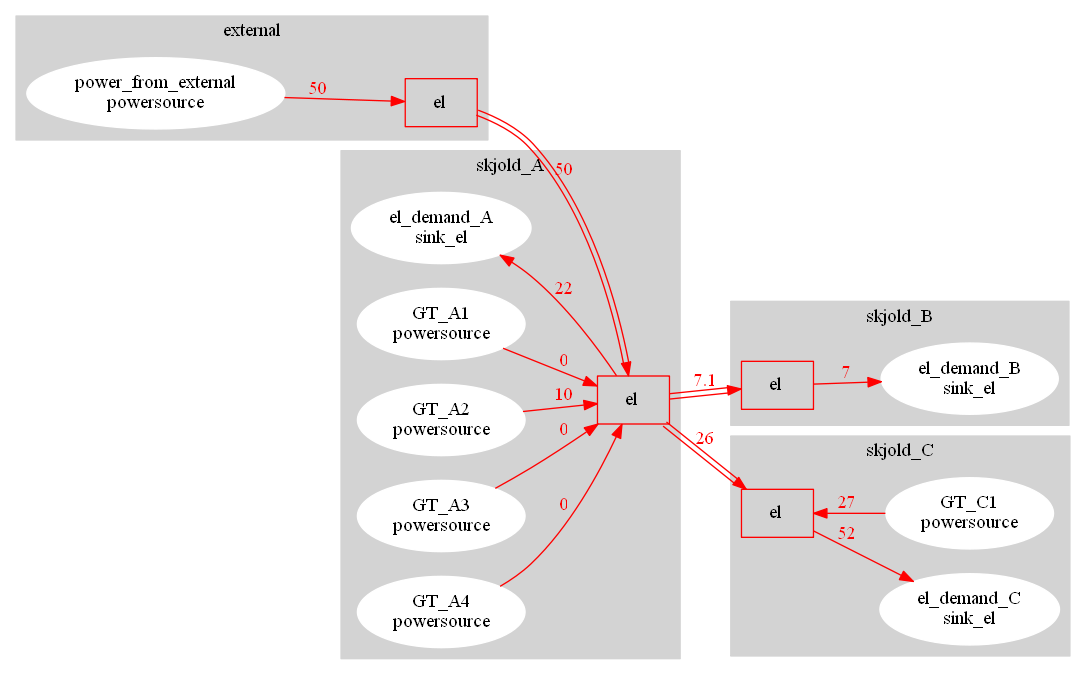

In [318]:
dotG=plots.plotNetwork(simulator=sim,timestep=1,filename=None,rankdir='LR')
IPython.display.Image(dotG.create_png())

INFO:root:[]


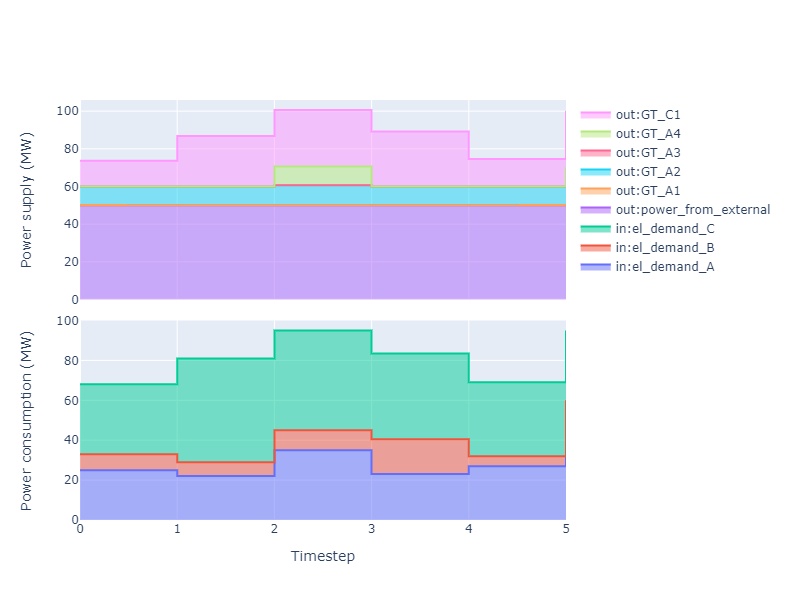

In [321]:
plots.plot_SumPowerMix(sim,"el")

<AxesSubplot:>

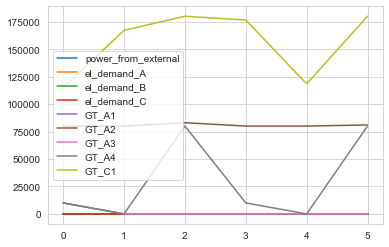

In [322]:
sim._dfPenalty.plot()

In [260]:
#sim.optimiser.pyomo_instance.varEdgeLoss12["e1",10]

<AxesSubplot:xlabel='x'>

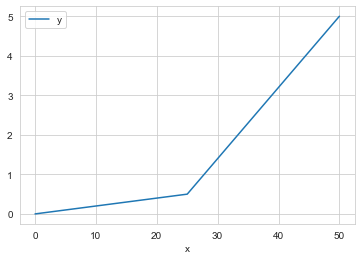

In [261]:
ploss_func=sim.optimiser.all_edges["e1"].edge_data.power_loss_function
plotdata=pd.DataFrame({'x': ploss_func[0], "y": ploss_func[1]}).set_index("x")
plotdata.plot()

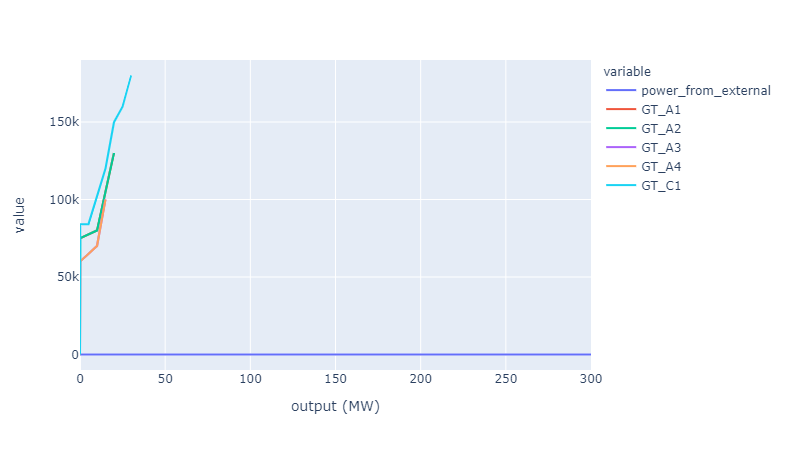

In [262]:
plotdata=[]
for d,dev in sim.optimiser.all_devices.items():
    if hasattr(dev.dev_data,"penalty_function"): 
        func=dev.dev_data.penalty_function
        plotdata.append(pd.DataFrame({'output (MW)': func[0], d: func[1]}).set_index("output (MW)"))
px.line(pd.concat(plotdata))#,xlim=[0,40])

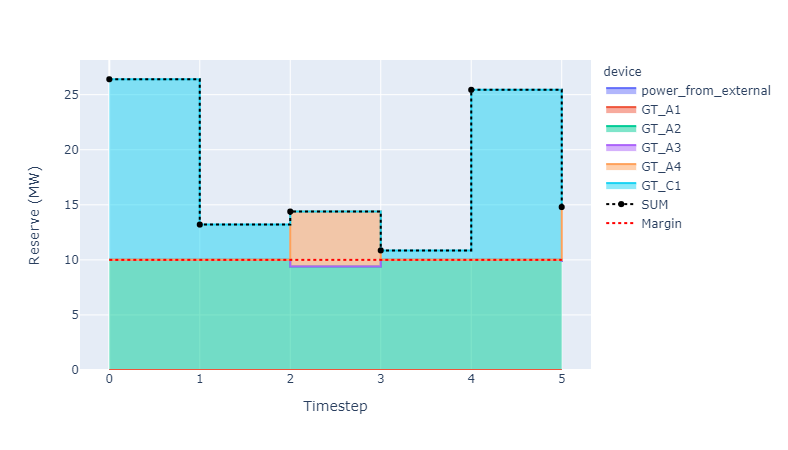

In [323]:
plots.plotReserve(sim)

In [324]:
#sim.optimiser.pyomo_instance.varDeviceIsOn.pprint()

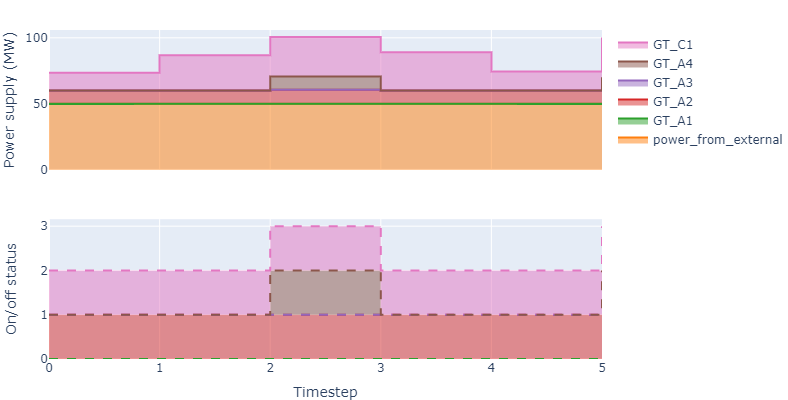

In [327]:
gts = [d for d,d_obj in sim.optimiser.all_devices.items() if d_obj.dev_data.model=='powersource']
fig=plots.plot_deviceprofile(simulator=sim,devs=gts,includeOnOff=True,includePrep=False)
fig.update_layout(autosize=False,width=800,height=400,margin=dict(l=0,r=0,t=30,b=0))

In [329]:
#sim._dfDeviceIsOn.unstack("device")

<AxesSubplot:>

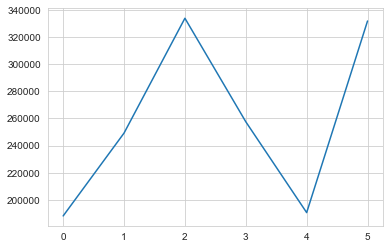

In [271]:
sim._dfPenalty.sum(axis=1).plot()

In [103]:
pyo.value(sim.optimiser.all_devices['GT_A1'].compute_penalty([3]))

0.0

In [181]:
#sim.optimiser.pyomo_instance.varDevicePenalty["GT_A1","el","out",:].pprint()

In [184]:
sim._dfElReserve

,reserve
0,56.600000
1,43.202857
2,29.387755
3,40.860000
4,55.640000
5,29.795918
